In [1]:
import os, math, csv, time, random

from sklearn.cluster import KMeans
from sklearn.datasets import make_circles, make_moons, make_blobs, make_swiss_roll, make_s_curve

import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial
import random

from pyspark import RDD, SparkConf, SparkContext

In [2]:
def dist(p1, p2):
    """Euclidean distance."""
    sub = [a_i - b_i for a_i, b_i in zip(p1, p2)]
    return np.linalg.norm(sub,2)

def closest(points,centers):
    mapping = []
    for point in points:
        closest_distance = float('inf')
        closest_center_idx = -1
        for idx, center in enumerate(centers):
            if dist(point,center) <= closest_distance:
                closest_distance = dist(point,center)
                closest_center_idx = idx
        mapping.append(closest_center_idx)
    return mapping

# Coreset using k-means++ initialization

In [3]:
def k_means_plus_plus(pointset, k):
    """Sample centroids using kMeans++ initialization.
    
    Returns
      centroids:  list of coordinates.
      distances:  list of tuples (distance, closest center)
        of each point's closest center and the distance towards it.
      cost:  cost of the calculated initial clustering.
    """


    n = len(pointset)

    # for each point (distance, closest center)
    # distance to it's closest center, -1 means +infty
    distances = [(-1, None) for _ in range(n)]

    # cumulative sum of squared distances
    cumulative = [0 for _ in range(n)]
    
    def update(centroid, idx):
        # update the closest centers and distances
        for j in range(n):
            x = dist(centroid, pointset[j])
            if x < distances[j][0] or distances[j][0] == -1:
                distances[j] = (x, (centroid, idx))
        
        # compute cumulative sum of squared distances
        cumulative[0] = distances[0][0] * distances[0][0]
        for j in range(1, n):
            cumulative[j] = cumulative[j-1] + distances[j][0] * distances[j][0]

    # sample first centroid uniformly at random
    centroids = [pointset[random.randint(0, n-1)]]
            
    # sample remaining k-1 centroids
    for i in range(1, k):
        update(centroids[i-1], i-1)

        # sample next centroid using cumulative sum
        x = random.random() * cumulative[-1]

        if x <= cumulative[0]:
            centroids.append(pointset[0])
        else:
            for j in range(1,n):
                if cumulative[j-1] < x <= cumulative[j]:
                    centroids.append(pointset[j])               
    
    # make sure to update for last added centroid
    update(centroids[-1],len(centroids)-1)

    return centroids, distances, cumulative[-1]

In [4]:
points = np.random.rand(50, 2)
centroids, distances, cost = k_means_plus_plus(points, 5)

def _calculate_cost_brute(points, centroids):
    """For testing purposes."""
    total = 0
    for p in points:
        min_dist = -1
        for c in centroids:
            x = dist(p, c)
            if x < min_dist or min_dist == -1:
                min_dist = x
        
        total += min_dist * min_dist
    
    return total

assert _calculate_cost_brute(points, centroids) == cost

In [5]:
points = np.random.rand(50, 2)
k = 5

centroids, distances, cost = k_means_plus_plus(points, k)

kmeans = KMeans(n_clusters=k, random_state=0).fit(points)
X_label = kmeans.labels_
ball_center = kmeans.cluster_centers_
km_cost = kmeans.inertia_ # Inertia = squared sum

In [6]:
def coreset(pointset, k, eps = 0.1):
    X = list(pointset).copy()
    centroids, distances, cost = k_means_plus_plus(pointset, k)
    
    a = 1 # IDK waar die a vandaan komt, en welke waarde dat ie moet hebben
    d = 2 # dimensinality <--- holy shit ik zie deze typaids nu pas

    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    X_label = kmeans.labels_
    ball_center = kmeans.cluster_centers_
    cost = kmeans.inertia_ # Inertia = squared sum

    r = math.sqrt(cost/(a*len(X)*math.log(len(X))))
    coreset = []

    while len(X)>0:
        x = eps*r / math.sqrt(d)

        grids = []
        z = 2*math.ceil(r/x)
        # We have z*z cells per ball
        # Initialize array that stores grids
        for i in range(k):
            # We make the squares for each ball.
            grid = [ [0]*z for i in range(z)]
            grids.append(grid)  

        for idx, point in enumerate(X):
            ball = X_label[idx] # The ball closest to this point.
            c = ball_center[ball] # Centre of this ball
            if dist(point,c) <= r: # The point lies inside the ball
                grid = grids[ball] # The grid of this ball
                # compute the grid cell
                hor_idx = math.floor((point[0]-c[0])/x)+math.ceil(r/x)
                ver_idx = math.floor((point[1]-c[1])/x)+math.ceil(r/x)
                if grid[hor_idx][ver_idx] == 0:
                    # The cell is still empty, so we indicate that the cell is no longer empty
                    grid[hor_idx][ver_idx] = 1
                    coreset.append(point)
                # The point has now been assigned to a (non-empty) cell so we can remove it from X and forget about it.
                X.pop(idx)
        #Double r for  next iteration.
        r = r*2
    return coreset

In [103]:
def coreset_plus_plus(pointset, k, eps = 0.1):
    centroids, distances, cost = k_means_plus_plus([p for p,_ in pointset], k)
    
    a = 1 # parameter used for approximation of OPT
    dim = len(pointset[0][0]) # dimensinality
    
    n = len([p for p,_ in pointset])
    r = math.sqrt(cost / (a * n * math.log(n)))
    coreset = []
    #coreset_weights = []
    
    

    # (p, (dist. to closest c, (coord's of closest c, index of closest c)))
    X = list(zip(pointset, distances))
    todo_list = [True for _ in X] # True means we still need to handle this point.
    
    while True in todo_list:
        x = eps * r / math.sqrt(dim)
        grids = []
        grids_point = []
        #print(r,x,r/x)
        z = 2 * math.ceil(r/x)
        
        
        
        # We have z*z cells per ball
        # Initialize array that stores grids
        for i in range(k):
            # We make the squares for each ball.
            grid = [ [0]*z for i in range(z) ]
            grid_point = [ [0]*z for i in range(z) ]
            grids.append(grid) 
            grids_point.append(grid_point)
        
        # TODO:     
        for idx, (p, (d, (c_coo, c_idx))) in enumerate(X):
            if todo_list[idx]:
                if d <= r: # p lies inside the ball
                    grid = grids[c_idx] # grid of this ball
                    grid_point = grids_point[c_idx] # For each grid we keep a point
                    # compute the grid cell
                    hor_idx = math.floor((p[0][0]-c_coo[0])/x)+math.ceil(r/x)
                    ver_idx = math.floor((p[0][1]-c_coo[1])/x)+math.ceil(r/x)
                    if grid[hor_idx][ver_idx] == 0:
                        #We have no point saved for this grid so we save it:
                        grid_point[hor_idx][ver_idx] = p[0]
                    # We increment the weight of the cell.
                    grid[hor_idx][ver_idx] += p[1]


                    # The point has now been assigned to a (non-empty) cell so we can remove it from X and forget about it.
                    todo_list[idx] = False

        r = r*2
        
        for idx_grid, grid in enumerate(grids):
            grid_point = grids_point[idx_grid]
            for i in range(z):
                for j in range(z):
                    if grid[i][j] > 0:
                        #coreset_weights.append(grid[i][j])
                        coreset.append((grid_point[i][j],grid[i][j]))
    return coreset #, coreset_weights

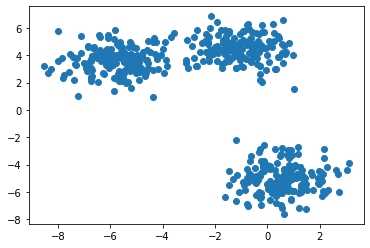

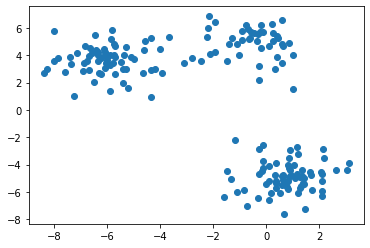

[(array([-6.74615186,  3.56822432]), 2),
 (array([-6.69374098,  3.92925839]), 4),
 (array([-6.55708807,  4.15335649]), 1),
 (array([-6.35402161,  3.57501244]), 1),
 (array([-6.34945369,  3.98886834]), 2),
 (array([-6.33624242,  4.22168441]), 1),
 (array([-6.41400456,  4.38703356]), 1),
 (array([-6.04701681,  3.43358413]), 3),
 (array([-6.2505841 ,  3.76592817]), 2),
 (array([-6.08900243,  4.01094063]), 2),
 (array([-6.0957381 ,  4.25800379]), 2),
 (array([-5.91258162,  3.26623409]), 1),
 (array([-5.78157847,  3.43586809]), 1),
 (array([-5.99530308,  3.64526552]), 1),
 (array([-5.91183953,  3.99199755]), 4),
 (array([-5.69362347,  3.84457428]), 2),
 (array([-5.74877462,  4.00596192]), 1),
 (array([-0.62382759,  5.25378991]), 1),
 (array([-0.68647862,  5.91532298]), 1),
 (array([-0.44663574,  5.63994863]), 1),
 (array([-0.56898276,  5.72628565]), 1),
 (array([-0.32337244,  5.53348437]), 1),
 (array([-0.21550056,  5.72610628]), 1),
 (array([-0.21086848,  6.16606201]), 1),
 (array([-0.1362

In [104]:
#X = list(np.random.rand(5000, 2))
X = list(make_blobs(n_samples=500)[0])

res = coreset_plus_plus([(p,1) for p in X], 3, 0.5)

def plot(X):
    plt.scatter(np.array(X)[:,0],np.array(X)[:,1])
    plt.show()
    
def plot(X, cluster = []):
    if len(cluster) == 0:
        plt.scatter(np.array(X)[:,0],np.array(X)[:,1])
    else:
        plt.scatter(np.array(X)[:,0],np.array(X)[:,1], c = cluster)
    plt.show()

plot(X)
plot([p for p,_ in res])
res

In [96]:
res

array([array([-5.99080061,  1.31900522]), 1,
       array([-6.12905975,  1.3622797 ]), 1,
       array([-5.87968497,  1.01111192]), 3,
       array([-5.97001873,  1.25182755]), 1,
       array([-5.8196112 ,  1.38413197]), 1,
       array([-5.97564222,  1.64655988]), 2,
       array([-5.76757063,  1.9057057 ]), 1,
       array([-5.73457114,  1.11875506]), 1,
       array([-5.54019266,  1.39675343]), 1,
       array([-5.52999695,  1.93578203]), 1,
       array([-5.3525403 ,  0.78205361]), 1,
       array([-5.50587197,  1.34184804]), 1,
       array([-5.35029779,  1.78127592]), 1,
       array([-5.04066088,  1.0352384 ]), 1,
       array([-5.13523317,  1.3321702 ]), 1,
       array([-5.22115623,  1.52580519]), 1,
       array([-5.00264577,  1.03948096]), 2,
       array([-1.78544169, -6.32460459]), 1,
       array([-1.86830801, -6.18295254]), 1,
       array([-1.76587852, -5.97380838]), 2,
       array([-1.56589401, -6.77591676]), 2,
       array([-1.58943946, -6.29667398]), 1,
       arr

# The parrallel stuff

In [105]:
conf = SparkConf().setAppName('Coreset')
sc = SparkContext.getOrCreate(conf=conf)


# This performs the action of going up one layer in the tree from the lectures,
# we give every partion an id, divide it by two such that two partitions share the same key.
# Then we group by the key. This halves the number of partitions. Then we throw away the keys and 
# we apply the flatmap to obtain one collection of points.
def mergeLayer(rdd):
    size = math.ceil(rdd.getNumPartitions()/2)
    return rdd.mapPartitionsWithIndex(lambda idx, a:  [(math.floor(idx/2),l) for l in a]).groupByKey(size).values().flatMap(list)


time taken 1.757967233657837


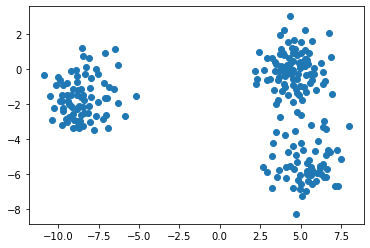

In [107]:
k = 3
eps = 0.2

X = list(make_blobs(n_samples=500)[0])



def CoresetMPC(X,k,eps):
    machines = math.floor(math.sqrt(len(X)))
    start_time = time.time()
    RDD = sc.parallelize([(p,1) for p in X], machines)

    partitions = RDD.getNumPartitions()
    while partitions > 1:
        RDD = RDD.mapPartitions(lambda points : coreset_plus_plus(list(points),k,eps)) #coreset_plus_plus(points,k,eps)
        RDD = mergeLayer(RDD)
        partitions = RDD.getNumPartitions()
    
    
    res = coreset_plus_plus(RDD.collect(),k,eps)
    end_time = time.time()
    points = [p for p,_ in r]
    weights = [w for _,w in r]
    return points, weights, end_time-start_time

p,w,t = CoresetMPC(X,k,eps)
print("time taken", t)

plot(p)


kmeans = KMeans(n_clusters=k).fit(p, sample_weight=w)
centers = kmeans.cluster_centers_

232
232


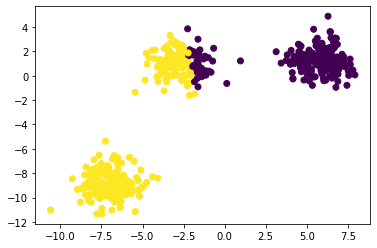

In [120]:

def k_meansMPC(X,k,eps):
    points,weights,t = CoresetMPC(X,k,eps)
    print(len(points))
    print(len(weights))
    kmeans = KMeans(n_clusters=k).fit(points, sample_weight=weights)
    centers = kmeans.cluster_centers_
    clusters = closest(X,centers)
    return clusters, centers

clusters, _ = k_meansMPC(X,3,eps)
plot(X, clusters)
            
        

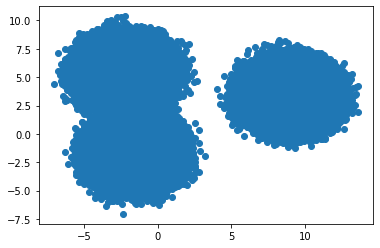

Time taken:  2.810487985610962


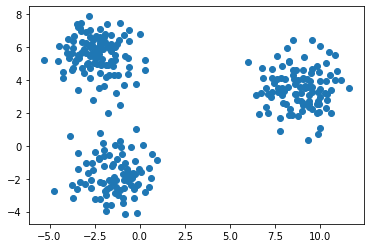

Time taken:  5.35197639465332


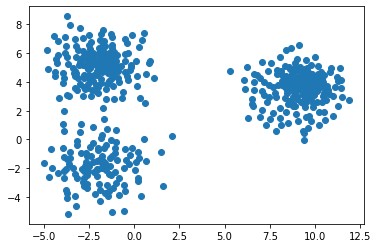

Time taken:  6.685573577880859


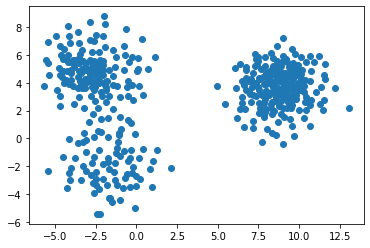

Time taken:  14.244511842727661


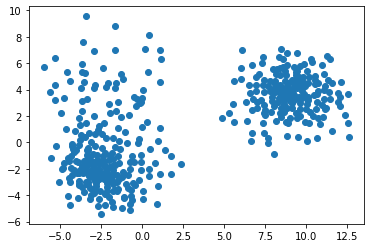

Time taken:  19.397956132888794


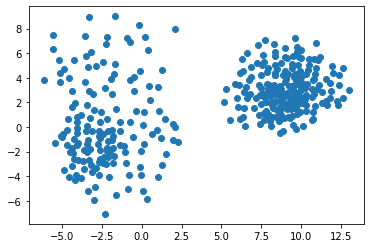

Time taken:  28.333842515945435


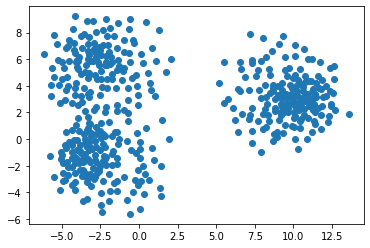

Time taken:  30.331019401550293


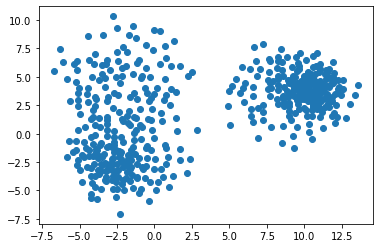

Time taken:  43.01028847694397


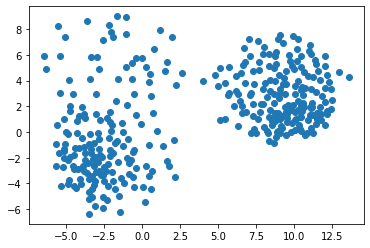

Time taken:  63.51779770851135


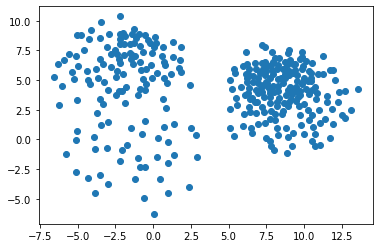

Time taken:  150.6217987537384


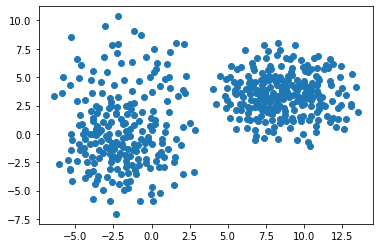

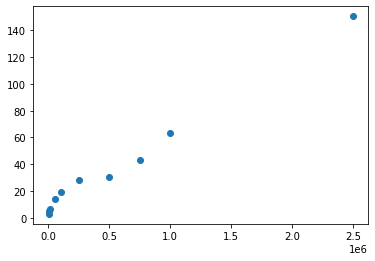

In [12]:
k = 3
eps = 0.2
#data = list(make_blobs(n_samples=2500000)[0])
plot(data)

sample_sizes = [1000,5000,10000,50000,100000,250000,500000,750000,1000000,2500000]
subdata = [random.sample(data, size) for size in sample_sizes]

results = [CoresetMPC(inp,k,eps) for inp in subdata]

for (p,w,t) in results:
    print("Time taken: ",t)
    plot(p)
    
times = [ t for (_,t) in results]
plt.plot(sample_sizes,times,'o')
plt.show()



Time taken:  2.810487985610962


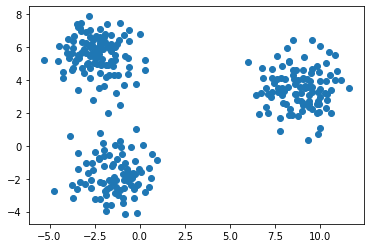

Time taken:  5.35197639465332


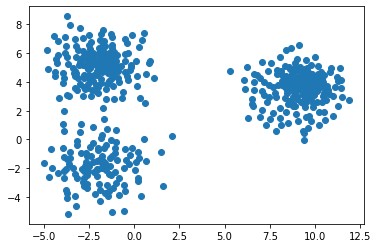

Time taken:  6.685573577880859


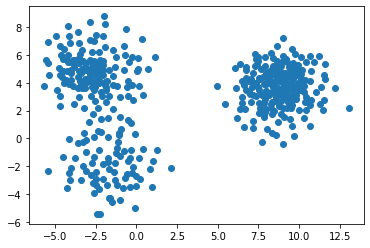

Time taken:  14.244511842727661


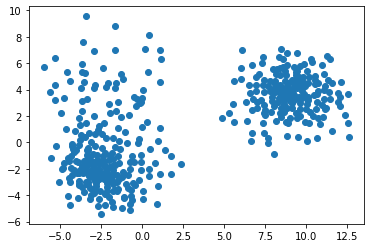

Time taken:  19.397956132888794


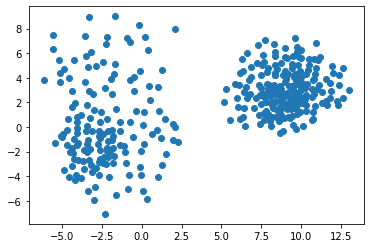

Time taken:  28.333842515945435


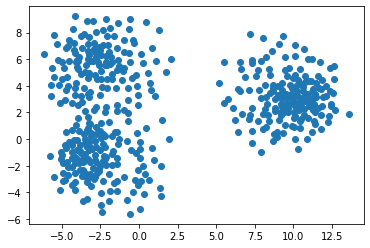

Time taken:  30.331019401550293


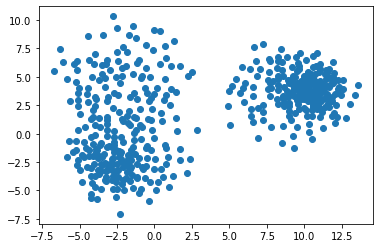

Time taken:  43.01028847694397


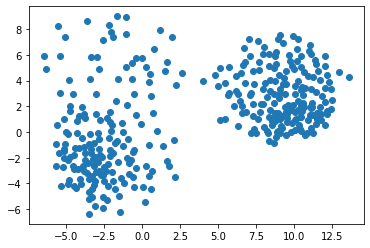

Time taken:  63.51779770851135


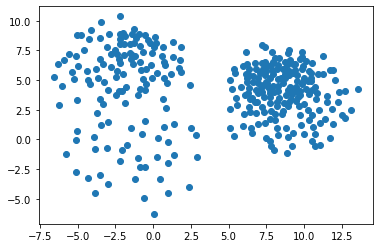

Time taken:  150.6217987537384


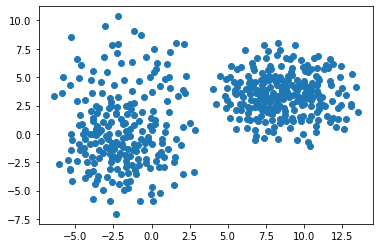

In [13]:
for (coreset,t) in results:
    print("Time taken: ",t)
    plot(coreset)

In [14]:
times = [ t for (_,_,t) in results]

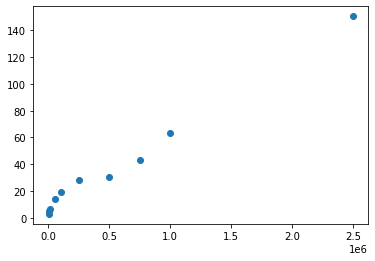

In [15]:
plt.plot(sample_sizes,times,'o')
plt.show()

# Images

In [109]:
import cv2
#pip3 install opencv-python

image = cv2.imread("Lenna.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [110]:
k = 4

times = []

plt.figure(figsize=(9 * 1.3 + 2, 24.5))

for idx, eps in enumerate([0.1]):
    start_time = time.time()
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)
    pixel_values
    clusters, centers = k_meansMPC(pixel_values, k, eps)
    centers = np.uint8(centers)
    segmented_image = np.array([centers[i] for i in clusters])
    segmented_image = segmented_image.reshape(image.shape)
    end_time = time.time()
    times.append(end_time-start_time)
    print("k: ", k, " Time taken ", end_time-start_time)

    plt.subplot(5,3,idx+1)
    plt.axis('off')
    plt.title("Epsilon = "+str(eps))
    plt.imshow(segmented_image)


plt.savefig("Different epsilon on Lenna, k = 10")

ValueError: cannot reshape array of size 524288 into shape (512,512,3)

<Figure size 986.4x1764 with 0 Axes>

Time taken  0.9961159229278564


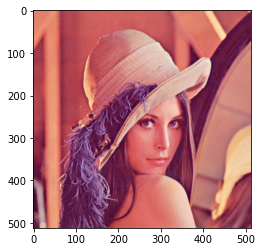

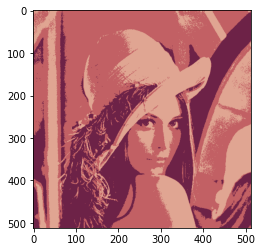

<Figure size 432x288 with 0 Axes>

In [108]:
k = 3


start_time = time.time()
pixel_values = image.reshape((-1, 3))
pixel_values = np.float32(pixel_values)
pixel_values

kmeans = KMeans(n_clusters=k).fit(pixel_values)
centers = kmeans.cluster_centers_
clusters = kmeans.labels_

centers = np.uint8(centers)
segmented_image = np.array([centers[i] for i in clusters])
segmented_image = segmented_image.reshape(image.shape)
end_time = time.time()
print("Time taken ", end_time-start_time)


plt.imshow(image)
plt.show()

plt.imshow(segmented_image)
plt.show()
plt.savefig(str(k))

In [21]:
times

[161.16029238700867,
 115.63627862930298,
 101.882483959198,
 102.82734298706055,
 102.70724606513977,
 85.13965153694153,
 96.99972724914551,
 81.10230660438538,
 81.13256931304932]

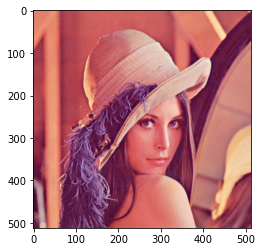

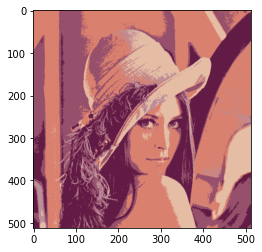

In [14]:
times

[46.30724382400513,
 54.18653464317322,
 60.83283519744873,
 60.893571615219116,
 62.04597616195679,
 74.19779133796692,
 91.4532082080841,
 91.29147863388062,
 120.06604599952698,
 118.22547483444214,
 133.66759419441223,
 139.23373532295227,
 144.91283226013184]

In [15]:
times

[60.60321760177612,
 58.06168007850647,
 55.28086853027344,
 55.552061319351196,
 54.85362648963928,
 55.579362869262695,
 54.26339340209961,
 54.314008474349976,
 54.015221118927]

In [23]:
grid_point = [ []*10 for i in range(10) ] 

In [26]:
grid_point[5] = ("y","z")

In [27]:
grid_point

[[], [], [], [], [], ('y', 'z'), [], [], [], []]

In [28]:
for d in grid_point:
    print(d)

[]
[]
[]
[]
[]
('y', 'z')
[]
[]
[]
[]
